# *Pump-it-up project*

### Can you predict which water pumps are faulty?

## Goal
Using data from Taarifa and the Tanzanian Ministry of Water, predict which pumps are functional, which need some repairs, and which don't work at all based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. 

A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

# II. Data Cleaning & Preprocessing
## 1. Libraries and input data

In [522]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
%matplotlib inline

print("Setup Complete")

Setup Complete


In [432]:
# Load the data after EDA
train_df = pd.read_csv("train_df_after_EDA.csv")
X_test = pd.read_csv("X_test_after_EDA.csv")

## 2. Dropping similar features

The following groups of features

- (extraction_type, extraction_type_group, extraction_type_class),
- (payment, payment_type),
- (water_quality, quality_group),
- (source, source_class),
- (subvillage, region, region_code, district_code, lga, ward),
- (waterpoint_type, waterpoint_type_group)
- (scheme_name, scheme_management)

contain very similar information, so the correlation between them is high. This way we are risking overfitting the training data by including all the features in our analysis.

Besides:

num_private is ~99% zeros and has no description, so we cannot interpret it
in the wpt_name feature 45k unique values out of 75k observations, not very informative -> drop for now

**TO DO**: The correlation between "construction_year" and "gps_height" is high, but these 2 variables don't have any obvious connection, so explore this correlation further to take a decision.

As we saw earlier, there exists quite a strong correlation between district_code and region_code, so we will drop one of these variables. The negative correlation to the target variable of the "region_code" is higher than that of the "district_code". Keep the variable with higher correlation to the target.

In [433]:
# drop columns
train_df = train_df.drop(['installer','management_group','status_group','id_x','id_y', 'num_private', 'wpt_name', 
          'recorded_by', 'subvillage', 'scheme_name', 'region', 
          'quantity', 'water_quality', 'lga','ward', 'source_type', 'payment', 
          'waterpoint_type_group','extraction_type_group','extraction_type_class'],axis=1)
X_test = X_test.drop(['installer','management_group','id', 'num_private', 'wpt_name', 
          'recorded_by', 'subvillage', 'scheme_name', 'region', 
          'quantity', 'water_quality', 'lga','ward', 'source_type', 'payment', 
          'waterpoint_type_group','extraction_type_group','extraction_type_class'],axis=1)

In [434]:
train_df.head()

,amount_tsh,date_recorded,funder,gps_height,longitude,latitude,basin,region_code,district_code,population,...,construction_year,extraction_type,management,payment_type,quality_group,quantity_group,source,source_class,waterpoint_type,label
0,6000.0,2011-03-14,Roman,1390,34.938093,-9.856322,Lake Nyasa,11,5,109,...,1999,gravity,vwc,annually,good,enough,spring,groundwater,communal standpipe,2
1,0.0,2013-03-06,Grumeti,1399,34.698766,-2.147466,Lake Victoria,20,2,280,...,2010,gravity,wug,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,2
2,25.0,2013-02-25,Lottery Club,686,37.460664,-3.821329,Pangani,21,4,250,...,2009,gravity,vwc,per bucket,good,enough,dam,surface,communal standpipe multiple,2
3,0.0,2013-01-28,Unicef,263,38.486161,-11.155298,Ruvuma / Southern Coast,90,63,58,...,1986,submersible,vwc,never pay,good,dry,machine dbh,groundwater,communal standpipe multiple,0
4,0.0,2011-07-13,Action In A,0,31.130847,-1.825359,Lake Victoria,18,1,0,...,0,gravity,other,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,2


## 3. Dealing with missing values

In [435]:
## Null scheme_management, funder, installer, public_meeting and permit values replace with "unknown" text
train_df["scheme_management"].fillna("unknown", inplace = True)
train_df["public_meeting"].fillna("unknown", inplace = True)
train_df["permit"].fillna("unknown", inplace = True)
train_df["funder"].fillna("unknown", inplace = True)
# train_df["installer"].fillna("unknown", inplace = True)

X_test["scheme_management"].fillna("unknown", inplace = True)
X_test["public_meeting"].fillna("unknown", inplace = True)
X_test["permit"].fillna("unknown", inplace = True)
X_test["funder"].fillna("unknown", inplace = True)
# X_test["installer"].fillna("unknown", inplace = True)

In [436]:
X_test.isna().sum().sort_values(ascending=False)

waterpoint_type      0
source_class         0
date_recorded        0
funder               0
gps_height           0
longitude            0
latitude             0
basin                0
region_code          0
district_code        0
population           0
public_meeting       0
scheme_management    0
permit               0
construction_year    0
extraction_type      0
management           0
payment_type         0
quality_group        0
quantity_group       0
source               0
amount_tsh           0
dtype: int64

## ** Transforming data to reduce skew
Uni-modal, skewed distributions could potentially be log transformed: 
* Longtitude
* GPS_hight
* Region_code

** For later

## 5. Reducing cardinality
### 5.1 Select features

In [442]:
# Get number of unique entries in each column with categorical data
cat_vars = train_df.select_dtypes(include='object').columns
object_nunique = list(map(lambda col: train_df[col].nunique(), cat_vars))
d = dict(zip(cat_vars, object_nunique))

# Print number of unique entries by column, in ascending order
sorted(d.items(), key=lambda x: x[1])

[('public_meeting', 3),
 ('permit', 3),
 ('source_class', 3),
 ('quantity_group', 5),
 ('quality_group', 6),
 ('payment_type', 7),
 ('waterpoint_type', 7),
 ('basin', 9),
 ('source', 10),
 ('management', 12),
 ('scheme_management', 13),
 ('extraction_type', 18),
 ('date_recorded', 356),
 ('funder', 1898)]

Based on the above analysis:

the "recorded_by" feature can be dropped as there is only 1 unique value, it doesn't help in predicting.

The columns in which values can be ordered we can perform an Ordinal encoding: 
* quality_group
* quantity_group
* payment_type

The cardinality of the following 2 features should be reduced to 10 and then one-hot encode them or try Binary encoding:
* scheme_managenemt
* extraction_type

What to do with the following 3? The cardinality is too high... : --> will drop at the first model run, later could try Frequency encoding,Binary encoding if reduce cardinality to at least 100.
* funder
* installer
* subvillage

The rest can be one-hot encoded as the cardinality is lower than 10:
* public_meeting # later -> Binary?
* permit # later-> Binary?
* source_class
* management_group
* waterpoint_type_group
* source_type
* basin

### 5.2 Scheme_management

In [443]:
train_df.scheme_management.value_counts()

VWC                 36793
WUG                  5206
unknown              3877
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [444]:
## scheme_management
def scheme_wrangler(row):
    if row['scheme_management']=='VWC':
        return 'vwc'
    elif row['scheme_management']=='WUG':
        return 'wug'
    elif row['scheme_management']=='Water authority':
        return 'wtr_auth'
    elif row['scheme_management']=='WUA':
        return 'wua'
    elif row['scheme_management']=='Water Board':
        return 'wtr_brd'
    elif row['scheme_management']=='Parastatal':
        return 'parastatal'
    elif row['scheme_management']=='Private operator':
        return 'pri_optr'
    elif row['scheme_management']=='SWC':
        return 'swc'
    elif row['scheme_management']=='Company':
        return 'company'
    else:
        return 'other'
train_df['scheme_management'] = train_df.apply(lambda row: scheme_wrangler(row), axis=1)
X_test['scheme_management'] = X_test.apply(lambda row: scheme_wrangler(row), axis=1)

### 5.3 Extraction_type

In [445]:
train_df.extraction_type.value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [446]:
## extraction_type
def extraction_wrangler(row):
    if row['extraction_type']=='gravity':
        return 'gravity'
    elif row['extraction_type']=='nira/tanira':
        return 'nira/tanira'
    elif row['extraction_type']=='submersible':
        return 'submersible'
    elif row['extraction_type']=='swn 80':
        return 'swn_80'
    elif row['extraction_type']=='mono':
        return 'mono'
    elif row['extraction_type']=='india mark ii':
        return 'india_mark_ii'
    elif row['extraction_type']=='afridev':
        return 'afridev'
    elif row['extraction_type']=='ksb':
        return 'ksb'
    elif row['extraction_type']=='windmill':
        return 'windmill'
    else:
        return 'other'
train_df['extraction_type'] = train_df.apply(lambda row: extraction_wrangler(row), axis=1)
X_test['extraction_type'] = X_test.apply(lambda row: extraction_wrangler(row), axis=1)

### 5.4 Funder

In [447]:
train_df.funder.value_counts()

Government Of Tanzania    9084
unknown                   3635
Danida                    3114
Hesawa                    2202
Rwssp                     1374
                          ... 
Muslim Society               1
Mbwana Omari                 1
Village Communi              1
Rajab Seleman                1
Agape Churc                  1
Name: funder, Length: 1898, dtype: int64

In [448]:
## funder
def funder_wrangler(row):  
    '''Keep top 8 values and set the rest to 'other'''

    if row['funder']=='Government Of Tanzania':
        return 'gov'
    elif row['funder']=='Danida':
        return 'danida'
    elif row['funder']=='Hesawa':
        return 'hesawa'
    elif row['funder']=='Rwssp':
        return 'rwssp'
    elif row['funder']=='World Bank':
        return 'world_bank'   
    elif row['funder']=='Kkkt':
        return 'kkkt'   
    elif row['funder']=='World Vision':
        return 'world_vision'  
    elif row['funder']=='Unicef':
        return 'unicef'
    else:
        return 'other'
    
train_df['funder'] = train_df.apply(lambda row: funder_wrangler(row), axis=1)
X_test['funder'] = X_test.apply(lambda row: funder_wrangler(row), axis=1)

## 6. Ordinal encoding of categorical data
Several categorical features can be encoded in a specific order that follows from the range of its values. By using ordinal encoding instead of one-hot encoding we will avoid creating numerious additional columns and provide some logic to the model on how to evaluate these features. For example for the quality_group variable, the higher the label, the better the water quality, the more likely a pump is functional.

### 6.1 Quality_group

In [449]:
train_df.quality_group.value_counts()

good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64

In [450]:
order_dict_quality = {"good":3,"salty":2,"milky":2,"colored":2,"fluoride":2,"unknown":1}
train_df["quality_group_code"] = [order_dict_quality[item] for item in train_df.quality_group]
del train_df["quality_group"]

X_test["quality_group_code"] = [order_dict_quality[item] for item in X_test.quality_group]
del X_test["quality_group"]

### 6.2 Quantity_group

In [451]:
train_df.quantity_group.value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64

In [452]:
order_dict_quantity = {"enough":3,"insufficient":2,"dry":2,"seasonal":2,"unknown":1}
train_df["quantity_group_code"] = [order_dict_quantity[item] for item in train_df.quantity_group] 
del train_df["quantity_group"]

X_test["quantity_group_code"] = [order_dict_quantity[item] for item in X_test.quantity_group] 
del X_test["quantity_group"]

### 6.3 Payment_type

In [453]:
train_df.payment_type.value_counts()

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

In [454]:
order_dict_payment = {"monthly":4,"annually":4,"on failure":3,"per bucket":3,"never pay":2,"unknown":1,"other":1}
train_df["payment_code"] = [order_dict_payment[item] for item in train_df.payment_type] 
del train_df["payment_type"]

X_test["payment_code"] = [order_dict_payment[item] for item in X_test.payment_type] 
del X_test["payment_type"]

### 6.4 Public_meeting

In [455]:
train_df.public_meeting.value_counts()

True       51011
False       5055
unknown     3334
Name: public_meeting, dtype: int64

In [456]:
order_dict_pub_meet = {True:2,False:1,"unknown":0}
train_df["public_meeting_code"] = [order_dict_pub_meet[item] for item in train_df.public_meeting] 
del train_df["public_meeting"]

X_test["public_meeting_code"] = [order_dict_pub_meet[item] for item in X_test.public_meeting] 
del X_test["public_meeting"]

### 6.5 Permit

In [457]:
train_df.permit.value_counts()

True       38852
False      17492
unknown     3056
Name: permit, dtype: int64

In [458]:
order_dict_permit = {True:2,False:1,"unknown":0}
train_df["permit_code"] = [order_dict_pub_meet[item] for item in train_df.permit] 
del train_df["permit"]

X_test["permit_code"] = [order_dict_pub_meet[item] for item in X_test.permit] 
del X_test["permit"]

## 7. Feature Engineering

Feature engineering is a powerful way to improve the model. We will create new variables based on the features in the dataset that will better describe the target.

### 7.1 Amount_tsh
Based on the EDA we have previously defined a threshold to separate functional and non-functional pumps. Let's create a new binary variable that reflects this information.

In [459]:
train_df.loc[train_df['amount_tsh'] < 200000, 'amount_tsh'] = 0
train_df.loc[train_df['amount_tsh'] >= 200000, 'amount_tsh'] = 1

X_test.loc[train_df['amount_tsh'] < 200000, 'amount_tsh'] = 0
X_test.loc[train_df['amount_tsh'] >= 200000, 'amount_tsh'] = 1

### 7.2 Combine longitude and latitude in one feature
In this section we tried to create a new variable that would combine both longitude and latitude using a zip method. 

Yellow spots - functional pumps, green - needs repair, purple - non-functional.

As we see, south-est and almost all central and south west pumps are mostly non-functional. Area around the capital (central-south part) is mostly functional as well as north-est pumps. The rest seems unclear. 

How to use this info for the model? Try to create clusters (for ex around big cities)?

I have tested this featureand realized that models are unable to process a tuple. We will use the linear discriminant analysis for these variables.

### 7.3 Linear Discriminant Analysis (LDA)

LDA helps reducing dimentiality by maximizing the difference between categories. In our highly dimentional model it is a great tool. We will use LDA for the following columns as all of them contain geographical information:
 
- latitude
- longitude
- gps_height

Reference: https://zlatankr.github.io/posts/2017/01/23/pump-it-up

In [437]:
LDA_cols = ["latitude","longitude","gps_height"]

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

train_df_sc = sc.fit_transform(train_df[LDA_cols])
X_test_sc = sc.transform(X_test[LDA_cols])

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=None)

train_df_lda = lda.fit_transform(train_df_sc, train_df.label.values.ravel())
X_test_lda = lda.transform(X_test_sc)

train_df = pd.concat((pd.DataFrame(train_df_lda), train_df), axis=1)
X_test = pd.concat((pd.DataFrame(X_test_lda), X_test), axis=1)
    
    
for i in LDA_cols:
    del train_df[i]
    del X_test[i]

In [441]:
train_df.rename(columns={0: "LDA_0",1:"LDA_1"},inplace=True)
X_test.rename(columns={0: "LDA_0",1:"LDA_1"},inplace=True)

### 7.4 Construction year
We will turn construction_year into a categorical column with bins containing the following values: '60s', '70s', '80s', '90s, '00s', '10s', 'unknown'.

In [464]:
def construction_wrangler(row):
    if row['construction_year'] >= 1960 and row['construction_year'] < 1970:
        return '60s'
    elif row['construction_year'] >= 1970 and row['construction_year'] < 1980:
        return '70s'
    elif row['construction_year'] >= 1980 and row['construction_year'] < 1990:
        return '80s'
    elif row['construction_year'] >= 1990 and row['construction_year'] < 2000:
        return '90s'
    elif row['construction_year'] >= 2000 and row['construction_year'] < 2010:
        return '00s'
    elif row['construction_year'] >= 2010:
        return '10s'
    else:
        return 'unknown'
    
train_df['construction_year'] = train_df.apply(lambda row: construction_wrangler(row), axis=1)
X_test['construction_year'] = X_test.apply(lambda row: construction_wrangler(row), axis=1)

### 7.5 Date_recorded
We will calculate the number of days past since the date_recorded of a particular pump till the most recent date of the dataset. The idea being that more recently recorded pumps might be more likely to be functional than non-functional. 

Let's first convert the column to type datetime. 

In [465]:
train_df.date_recorded = pd.to_datetime(train_df.date_recorded)
X_test.date_recorded = pd.to_datetime(X_test.date_recorded)

train_df.date_recorded.describe()

count                   59400
unique                    356
top       2011-03-15 00:00:00
freq                      572
first     2002-10-14 00:00:00
last      2013-12-03 00:00:00
Name: date_recorded, dtype: object

In [466]:
# The most recent data is 2013-12-03. Subtract each date from this point to obtain a 
# 'days_since_recorded' column.

train_df['days_since_recorded'] = pd.datetime(2013, 12, 3) - pd.to_datetime(train_df.date_recorded)
train_df['days_since_recorded'] = train_df['days_since_recorded'].astype('timedelta64[D]').astype(int)

X_test['days_since_recorded'] = pd.datetime(2013, 12, 3) - pd.to_datetime(X_test.date_recorded)
X_test['days_since_recorded'] = X_test['days_since_recorded'].astype('timedelta64[D]').astype(int)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  import sys


In [467]:
train_df['days_since_recorded']

0         995
1         272
2         281
3         309
4         874
         ... 
59395     214
59396     941
59397     967
59398    1001
59399     986
Name: days_since_recorded, Length: 59400, dtype: int64

In [468]:
train_df = train_df.drop("date_recorded",axis=1)
X_test = X_test.drop("date_recorded",axis=1)

In [469]:
train_df.shape

(59400, 22)

In [470]:
X_test.shape

(14850, 21)

## 8. One-hot encoding of categorical features

In [471]:
cat_vars = train_df.select_dtypes(include='object').columns
print(cat_vars)
len(cat_vars)

Index(['funder', 'basin', 'scheme_management', 'construction_year',
       'extraction_type', 'management', 'source', 'source_class',
       'waterpoint_type'],
      dtype='object')


9

In [482]:
from sklearn.preprocessing import OneHotEncoder

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(train_df[cat_vars])).astype(np.int64)
OH_cols_test = pd.DataFrame(OH_encoder.transform(X_test[cat_vars])).astype(np.int64)

# One-hot encoding removed index; put it back
OH_cols_train.index = train_df.index
OH_cols_test.index = X_test.index

OH_cols_train.columns = OH_encoder.get_feature_names(cat_vars)
OH_cols_test.columns = OH_encoder.get_feature_names(cat_vars)

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = train_df.drop(cat_vars, axis=1)
num_X_valid = X_test.drop(cat_vars, axis=1)

# Add one-hot encoded columns to numerical features
OH_train_df = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_test = pd.concat([num_X_valid, OH_cols_test], axis=1)

In [483]:
OH_train_df.head()

,LDA_0,LDA_1,amount_tsh,region_code,district_code,population,label,quality_group_code,quantity_group_code,payment_code,...,source_class_groundwater,source_class_surface,source_class_unknown,waterpoint_type_cattle trough,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
0,0.393952,0.817902,0.0,11,5,109,2,3,3,4,...,1,0,0,0,1,0,0,0,0,0
1,0.580239,1.027575,0.0,20,2,280,2,3,2,2,...,0,1,0,0,1,0,0,0,0,0
2,-0.411278,0.318203,0.0,21,4,250,2,3,3,3,...,0,1,0,0,0,1,0,0,0,0
3,-1.036210,-0.324573,0.0,90,63,58,0,3,2,2,...,1,0,0,0,0,1,0,0,0,0
4,-0.070855,-0.911349,0.0,18,1,0,2,3,2,2,...,0,1,0,0,1,0,0,0,0,0


## 9. Feature selection
### 9.1 L1 regularization with logistic regression

In [484]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

X, y = OH_train_df[OH_train_df.columns.drop("label")], OH_train_df['label']

# Set the regularization parameter C=1
logistic = LogisticRegression(solver="saga",C=1, penalty="l1", random_state=7).fit(X, y)
model = SelectFromModel(logistic, prefit=True)

X_new = model.transform(X)
X_new

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


array([[ 0.39395219,  0.81790228, 11.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.58023946,  1.02757534, 20.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.41127849,  0.31820282, 21.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.59598342, -0.89729249, 12.        , ...,  1.        ,
         0.        ,  0.        ],
       [-0.80255208, -0.69781717,  1.        , ...,  1.        ,
         0.        ,  0.        ],
       [-0.95931514, -0.31560093,  5.        , ...,  1.        ,
         0.        ,  0.        ]])

In [485]:
# Get back the kept features as a DataFrame with dropped columns as all 0s
selected_features = pd.DataFrame(model.inverse_transform(X_new), 
                                 index=X.index,
                                 columns=X.columns)

# Dropped columns have values of all 0s, keep other columns 
selected_columns = selected_features.columns[selected_features.var() != 0]

In [501]:
len(selected_columns)

80

In [502]:
selected_columns

Index(['LDA_0', 'LDA_1', 'region_code', 'district_code', 'population',
       'quality_group_code', 'quantity_group_code', 'payment_code',
       'public_meeting_code', 'permit_code', 'days_since_recorded',
       'funder_danida', 'funder_gov', 'funder_hesawa', 'funder_other',
       'funder_rwssp', 'funder_unicef', 'funder_world_bank',
       'funder_world_vision', 'basin_Internal', 'basin_Lake Nyasa',
       'basin_Lake Rukwa', 'basin_Lake Tanganyika', 'basin_Lake Victoria',
       'basin_Pangani', 'basin_Rufiji', 'basin_Ruvuma / Southern Coast',
       'basin_Wami / Ruvu', 'scheme_management_company',
       'scheme_management_other', 'scheme_management_parastatal',
       'scheme_management_pri_optr', 'scheme_management_swc',
       'scheme_management_vwc', 'scheme_management_wtr_auth',
       'scheme_management_wtr_brd', 'scheme_management_wua',
       'scheme_management_wug', 'construction_year_00s',
       'construction_year_10s', 'construction_year_60s',
       'construction_ye

In [509]:
train_df_selected_features = OH_train_df[selected_columns].join(y)

In [504]:
X_test_selected_features = OH_X_test[selected_columns]

### 9.2 Feature importances with Random Forest

In [491]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(criterion='gini',min_samples_split=8, n_estimators=1000,
                           random_state = 7)
rf.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

In [492]:
# helper function for creating a feature importance dataframe
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title):
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue') \
       .set_title(title, fontsize = 20)

In [493]:
base_imp = imp_df(X.columns, rf.feature_importances_)
top_30_imp = base_imp[0:30]
top_30_features = top_30_imp.feature

In [499]:
pylab.rcParams["figure.figsize"] = (10,10)

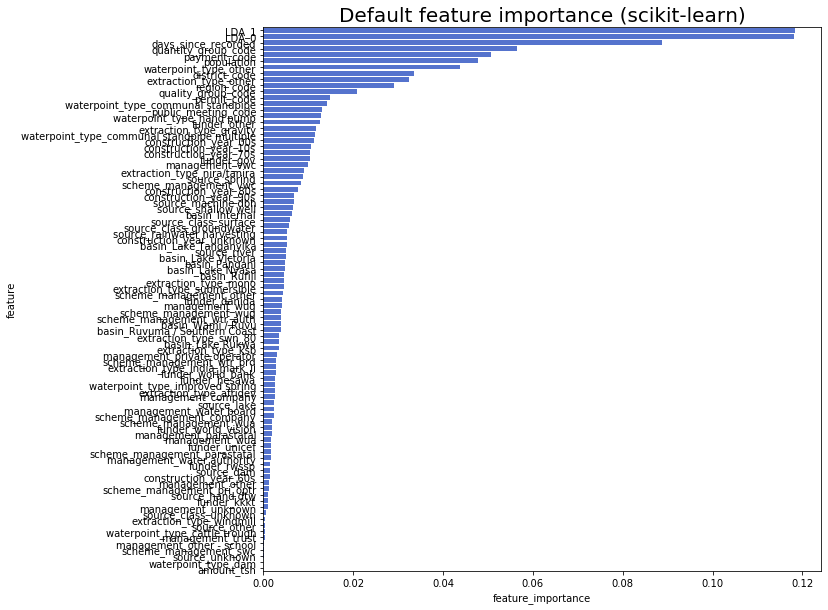

In [500]:
var_imp_plot(base_imp, 'Default feature importance (scikit-learn)')

In [505]:
train_df_final_top_imp = OH_train_df[top_30_features].join(y)
X_test_final_top_imp = OH_X_test[top_30_features]

In [507]:
train_df_final_top_imp.shape

(59400, 31)

In [511]:
train_df_selected_features.shape

(59400, 81)

## 10. Export the final dfs

In the part *III. Model selection* I have tested different models with these 2 final sets of variables (80 vars and 30 vars). The result seems to be stable across all the models - the set of 80 variables we received after doing L1 regularization with logistic regression scores higher every time. I am thus using the selected_features dfs as the final input.

In [513]:
train_df_selected_features.to_csv("train_df_final.csv", index=False)
X_test_selected_features.to_csv("X_test_final.csv", index=False)